# IMA205 - Challenge:Pap smear cells classification
##Júlia TOGASHI DE MIRANDA

### Index

1. Introduction
2. Importing data and libraries
3. Exploring the data
4. Metrics
5. Feature extraction
6. Methods over extracted features 
7. Convolutional neural network (CNN)
8. Conclusion
9. References

# 1. Introduction

This notebook contains the code and report for the IMA205 course challenge of 2021.The challenge consists in two problems: a binary classification and a multiclass classification. The dataset is a combination of two public datasets, that can be found in [[1]]( https://mde-lab.aegean.gr/downloads). It contains 4173 RGB images of Pap smear cells with their relative segmentations of the nucleus and cytoplasma, dived as 70% for train and 30% for test (which we don’t have the labels).<br><br>
The goal is to test different machine learning methods seen in the course, and with the available references that can be seen bellow, try to get the best results.


# 2. Importing data and libraries

In [ ]:
# All the used libraries 
import numpy as np
import pandas as pd
import numpy.matlib
import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt
plt.close('all')

import re
import glob
import cv2
import time

import scipy.ndimage as ndi
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.stats import skew

from skimage.io import imread
from skimage.measure import shannon_entropy

from sklearn.utils import class_weight
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D, GlobalAveragePooling2D, Average,UpSampling2D
from tensorflow.keras import optimizers
print(tf.keras.__version__)

2.4.0


The data for this work was available in the Kaggle’s competition page. It consists in two folders, one containing the training images and the other the testing images. For each cell, there is one image of the cell seen through a microscope; the mask that corresponds to de cytoplasm segmentation of that cell and the mask that corresponds to the nucleus segmentation to that cell, all them in .bmp format.<br><br>
In addition to that, we have a .csv that contains the id of all the cells in the testing set, the classification of the cell as normal/abnormal (which will be used in the binary classification problem) and the group to each that cell belongs (which will be used in the multiclass classification problem).<br><br>

**All the data was loaded to my Google Drive and should be accessible through the ids bellow.**


In [ ]:
# Challenge data has been uploaded to the Google drive

if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1d0Qr_1E_qZPc1MuKfUN6bhCa88-6eljl',
                                      dest_path='./Train.zip',
                                      unzip=True)
  
  gdd.download_file_from_google_drive(file_id='1vWI_yuX6DPIddLCROM2rWpKGjvSe3FfY',
                                      dest_path='./metadataTrain.csv')
  
  gdd.download_file_from_google_drive(file_id='1poX11KjWYgq5pk3ybxXSYBgHpXOnJzHq',
                                      dest_path='./Test.zip',
                                      unzip=True)
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Modify working_dir if you are not using Google Colab)
Working_directory="./"  

The functions used bellow were taken from a practical work of the course, they allow us to obtain 3 different vectors, that contains, each one, one type of image.

In [ ]:
%%capture
Train_path = Working_directory + 'Train'
!ls './Train'

# Getting arrays for the cell’s images, the cytoplasm segmentation and the nucleus segmentation respectively 
import glob
images = glob.glob(Train_path + '/*[0-9].bmp')
segCyt = glob.glob(Train_path + '/*_segCyt.bmp')
segNuc = glob.glob(Train_path + '/*_segNuc.bmp')


In [ ]:
# Checking if the number of images is right 
print('There are', len(segCyt),  'cytoplasm segmentation')
print('There are', len(segNuc),  'nucleus segmentation')
print('There are', len(images),  'train images')

There are 2921 cytoplasm segmentation
There are 2921 nucleus segmentation
There are 2921 train images


In [ ]:
%%capture
Test_path = Working_directory + 'Test'
!ls './Test'

# Getting arrays for the cell’s images, the cytoplasm segmentation and the nucleus segmentation respectively 
import glob
test_images = glob.glob(Test_path + '/*[0-9].bmp')
test_segCyt = glob.glob(Test_path + '/*_segCyt.bmp')
test_segNuc = glob.glob(Test_path + '/*_segNuc.bmp')


In [ ]:
# Checking if the number of images is right 
print('There are', len(test_segCyt),  'cytoplasm segmentation')
print('There are', len(test_segNuc),  'nucleus segmentation')
print('There are', len(test_images),  'test images')

There are 1252 cytoplasm segmentation
There are 1252 nucleus segmentation
There are 1252 test images


In [ ]:
# Sorting arrays of images
test_images.sort(key=lambda f: int(re.sub('\D', '', f)))
test_segCyt.sort(key=lambda f: int(re.sub('\D', '', f)))
test_segNuc.sort(key=lambda f: int(re.sub('\D', '', f)))

# Getting ids of test set for submission
test_ids = np.zeros(len(test_images)).astype(int)
for i in range(0,len(test_images)):
    test_ids[i] = test_images[i].replace('.bmp', '').replace("./Test/","")


In [ ]:
#Loading classes for each image in training dataset
classes = pd.read_csv("metadataTrain.csv")
classes.head()

,ID,ABNORMAL,GROUP
0,1721,1,8
1,311,0,1
2,1502,1,7
3,4227,0,1
4,3604,1,7


As can be seen above, the arrays containing the images and both nucleus and cytoplasm segmentation are randomly ordered. So is the class information. To easily match the images to their classes, they will be sorted in ascending order, matched so that they can be randomly sorted again (this time shuffled coherently between them).<br><br>
Randomly shuffling the data is usually important so that there is no regular pattern in it.


In [ ]:
# Sorting arrays of images
images.sort(key=lambda f: int(re.sub('\D', '', f)))
segCyt.sort(key=lambda f: int(re.sub('\D', '', f)))
segNuc.sort(key=lambda f: int(re.sub('\D', '', f)))

print("After sorting:")
print(images[0:5])
print(segCyt[0:5])
print((segNuc[0:5]))

# Sorting classes info
classes = classes.sort_values("ID")
print("\n\n", classes.head())

#Splitting dataset into useful nparrays
id = classes["ID"].to_numpy()
abnormal = classes["ABNORMAL"].to_numpy()
group = classes["GROUP"].to_numpy()
print("\nids: ",id[0:5])
print("abnormal: ",abnormal[0:5])
print("group: ",group[0:5])

After sorting:
['./Train/2.bmp', './Train/4.bmp', './Train/6.bmp', './Train/8.bmp', './Train/9.bmp']
['./Train/2_segCyt.bmp', './Train/4_segCyt.bmp', './Train/6_segCyt.bmp', './Train/8_segCyt.bmp', './Train/9_segCyt.bmp']
['./Train/2_segNuc.bmp', './Train/4_segNuc.bmp', './Train/6_segNuc.bmp', './Train/8_segNuc.bmp', './Train/9_segNuc.bmp']


       ID  ABNORMAL  GROUP
1588   2         0      1
524    4         0      1
625    6         1      5
162    8         0      1
917    9         1      8

ids:  [2 4 6 8 9]
abnormal:  [0 0 1 0 1]
group:  [1 1 5 1 8]


# 3. Exploring the data

## 3.1. Plotting images  

First, lets take a look at the images that are at our disposal. 

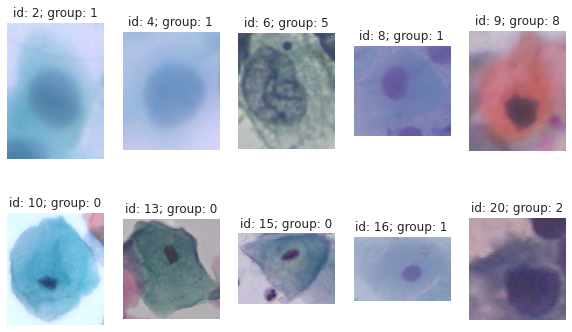

In [ ]:
# Plotting examples from first images
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    ima = imread(images[idx])
    plt.imshow(ima)
    plt.axis('off')
    plt.title("id: "+str(id[idx])+"; group: "+ str(group[idx]))
plt.show()

The first thing that can be noticed is that the images have different sizes. This is expected, as they come from different datasets. Also, to a person that has now prior knowledge in medicine, they seem to vary a lot. The 2nd and 5th cells from the first row above for example are from the same group and they don’t have a similar color, area of the nucleus and not even its shape. <br> <br>
Now let's take a look at the masks and how they behave.



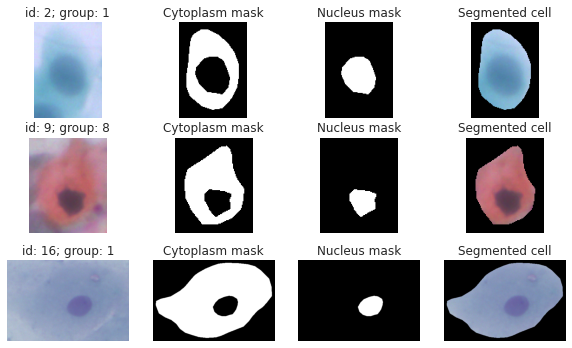

In [ ]:
# Plotting examples from first images
plt.figure(figsize=(10, 6))
for idx in range(0,12,4):
    # image
    plt.subplot(3, 4, idx+1)
    ima = imread(images[idx])
    plt.imshow(ima)
    plt.axis('off')
    plt.title("id: "+str(id[idx])+"; group: "+ str(group[idx]))
    # Cytoplasm mask 
    plt.subplot(3, 4, idx+2)
    cyt = imread(segCyt[idx])
    plt.imshow(cyt, cmap="gray")
    plt.axis('off')
    plt.title("Cytoplasm mask")
    # Nucleus mask 
    plt.subplot(3, 4, idx+3)
    nuc = imread(segNuc[idx])
    plt.imshow(nuc, cmap="gray")
    plt.axis('off')
    plt.title("Nucleus mask")
    # Segmented cell 
    plt.subplot(3, 4, idx+4)
    ima = imread(images[idx])
    cyt_3D = np.expand_dims((cyt/255).astype(np.uint8), axis=2) # To have a binary mask for the three channels (RGB)
    nuc_3D = np.expand_dims((nuc/255).astype(np.uint8), axis=2)
    plt.imshow(ima*(cyt_3D+nuc_3D))
    plt.axis('off')
    plt.title("Segmented cell")
plt.show()

##3.2. Distribution of datapoints   

At last, we will take a look at how is the frequency of examples in our dataset, both for the normal/abnormal case, as well as for each individual group. This is important as if we apply a machine learning method over a very unbalanced dataset, the tendency will be that it will classify the least frequent class as the most frequent class.  


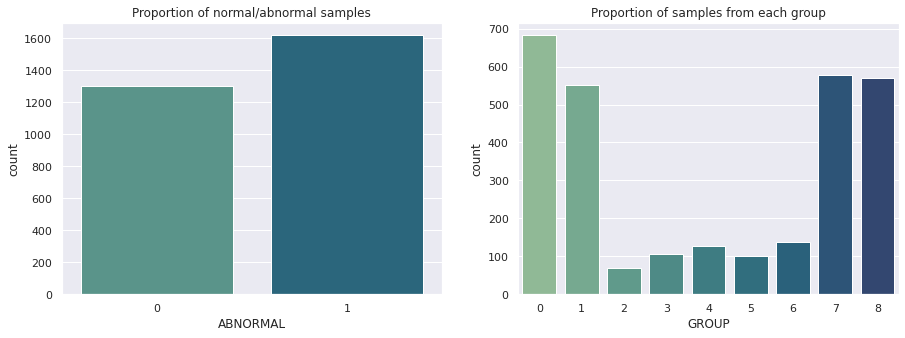

In [ ]:
plt.figure(figsize=(15, 5))
#abnormal distribution 
plt.subplot(1,2,1)
ax = sns.countplot(x="ABNORMAL", data=classes,palette="crest")
plt.title('Proportion of normal/abnormal samples')
#groups distribution 
plt.subplot(1,2,2)
ax = sns.countplot(x="GROUP", data=classes,palette="crest")
plt.title('Proportion of samples from each group')
plt.show()

In [ ]:
# Getting which groups are normal/ abnormal.
print("Normal groups: ",sorted(classes[classes["ABNORMAL"]==0].GROUP.unique()))
print("Abnormal groups: ",sorted(classes[classes["ABNORMAL"]==1].GROUP.unique()))

Normal groups:  [0, 1, 2]
Abnormal groups:  [3, 4, 5, 6, 7, 8]


For our first case, the binary classification, the classes aren’t evenly distributed, however the difference isn’t so big (about 45% of the datapoints are normal versus 55% abnormal). From a medical point of view, it can even be considered favorizing the abnormal class to be more interesting, as the cost of making mistakes is not equal for both cases. That is, the mistake of classifying a normal cell as abnormal is to have some specialist analyzing the case, or redoing the test. On the other hand, classifying an abnormal cell as normal can cause complications, or even cost the patients life. <br><br>
For the group classes on the other hand, the imbalance can cause problems, as the groups 2-6 are considerably less frequent that 0,1,7 and 8. In that case, actions might have to be taken to even out the frequency between groups. Also, as can be seen above, the normal cells are distributed in groups 0,1,2 and abnormal in the rest. Mistakenly classifying a abnormal cell as an abnormal cell, but from another group, should be considered a smaller mistake than classifying it as a normal cell.


# 4. Metrics

## 4.1. Binary Classification Problem

For the binary classification task we will use the Matthews correlation coefficient . It is defined as:

$$MCC = \frac{TP\times TN - FP\times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

Where TP is the number of true positives, TN the number of true negatives, FP the number of false positives and FN the number of false negatives.<br><br>

The implementation in python can be found bellow. 

In [ ]:
# Matthews correlation coefficient
def MCC(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

## 4.2. Multi-class Classification Problem

For the multiclass classification task we will use the Weighted Categorization Accuracy which is defined as:

$$WA=\frac{1}{N}\sum_{i=1}^{N}w_iI(y_i=f_i)$$

Such that: $\sum_{i=1}^{N} w_i=N$

#5. Feature extraction

One of the challenges of this project is that we only have at our disposal the images and segmentations of the cells, unlike in the practical labs, where usually the features were already extracted (for example for the melanoma cells classification).<br><br>
The first challenge is to find out which features might be useful for the classification problem. A solution to that is to search references from the field. In [[2]](https://ieeexplore.ieee.org/document/8451588) a list of relevant features can be found, and it will be what I will be using.<br><br>
One second difficult is to extract the features correctly. Not only the formula used to extract them might not be adequate, but there are a lot of other elements that can affect the results, such as the microscope/camera used to obtain the image. As the examples comes form different datasets, and there is no way to know from each one, there is no easy way to correct that.<br><br>
At last, this difficult us to interpret the results correctly. A bad result might be due to indeed the method not been adequate to our dataset, or it might be due to a bad feature extraction.<br><br>
Below is the list of features that I will be trying to extract, these features will be extracted both for the nucleus region and for the cytoplasm region, resulting in a total of 24 features (in all three color channels):<br><br>


*   Intensity:

  *   Average intensity: Average of pixels.
  *   Average contrast: Root mean square (RMS) was chosen as it does not depend on the angular frequency content or the spatial distribution of contrast in the image. It is defined as the standard deviation of the pixel intensities.

*   Texture
  *   Smoothness:  is a function of the color gradients
  *   Uniformity: formula used was $Percent\; Image\;Uniformity(PIU) = {1 −\frac{ (max−min)}{(max+min)} } \times 100\%$, an was obtained [here](http://mriquestions.com/image-uniformity.html).
  *   Entropy: skimage implamentation of shannon entropy.

*   Shape
  *   area
  *   major axis length
  *   minor axis length
  *   eccentricity
  *   orientation
  *   equivalent diameter
  *   Extent

An explanation of the meaning of most area features can be found [here](http://www.molvis.org/molvis/v21/appendices/mv-v21-40-app-9.pdf)



In [ ]:
# Intensity funcs

def average_intensity(img, segCyt_3D, segNuc_3D):
#- Input:  Image
#          3 channel mask of cytoplasm (binary)
#          3 channel mask of nucleus (binary)
#- Output: average_intensity of cytoplasm
#	         average_intensity of nucleus

  int_cyt = np.average(img,axis=None,weights=segCyt_3D)
  int_nuc = np.average(img,axis=None,weights=segNuc_3D)
  return int_cyt, int_nuc
  
def average_contrast(img, segCyt_3D, segNuc_3D):
# RMS contrast
#- Input:  Image
#          3 channel mask of cytoplasm (binary)
#          3 channel mask of nucleus (binary)
#- Output: average_contrast of cytoplasm
#	         average_contrast of nucleus
  segCyt_3D = segCyt_3D.astype('float')
  segCyt_3D[segCyt_3D == 0] = np.nan
  segNuc_3D = segNuc_3D.astype('float')
  segNuc_3D[segNuc_3D == 0] = np.nan
  cont_cyt = np.nanstd(img*segCyt_3D)
  cont_nuc = np.nanstd(img*segNuc_3D)
  return cont_cyt, cont_nuc

In [ ]:
# Texture funcs

def smoothness(img, segCyt_3D, segNuc_3D):
# smoothness is a function of the color gradients
#- Input:  Image
#          3 channel mask of cytoplasm (binary) 
#          3 channel mask of nucleus (binary)
#- Output: smoothness of cytoplasm
#	         smoothness of nucleus
  smo_cyt = np.average(np.absolute(ndi.filters.laplace((img*segCyt_3D).astype(float))))
  smo_nuc = np.average(np.absolute(ndi.filters.laplace((img*segNuc_3D).astype(float))))
  return smo_cyt, smo_nuc

def uniformity(img, segCyt_3D, segNuc_3D):
# Percent Image Uniformity(PIU) = {1 − (max−min) / (max+min) } x 100% 
#- Input:  Image
#          3 channel mask of cytoplasm (binary) 
#          3 channel mask of nucleus (binary)
#- Output: uniformity of cytoplasm
#	         uniformity of nucleus
  segCyt_3D = segCyt_3D.astype('float')
  segCyt_3D[segCyt_3D == 0] = np.nan
  segNuc_3D = segNuc_3D.astype('float')
  segNuc_3D[segNuc_3D == 0] = np.nan
  uni_cyt = 1.0 - (np.nanmax(img*segCyt_3D)-np.nanmin(img*segCyt_3D))/(np.nanmax(img*segCyt_3D)+np.nanmin(img*segCyt_3D))
  uni_nuc = 1.0 - (np.nanmax(img*segNuc_3D)-np.nanmin(img*segNuc_3D))/(np.nanmax(img*segNuc_3D)+np.nanmin(img*segNuc_3D))
  return uni_cyt, uni_nuc

def entropy(img, segCyt_3D, segNuc_3D):
#- Input:  Image
#          3 channel mask of cytoplasm (binary)
#          3 channel mask of nucleus (binary)
#- Output: entropy of cytoplasm
#	         entropy of nucleus
  entr_cyt = shannon_entropy(np.mean(img*segCyt_3D,axis=2,dtype=int))
  entr_nuc = shannon_entropy(np.mean(img*segNuc_3D,axis=2,dtype=int))
  return entr_cyt, entr_nuc

In [ ]:
# Shape funcs

def area(img, segCyt_3D, segNuc_3D):
#- Input:  Image
#          3 channel mask of cytoplasm (binary) 
#          3 channel mask of nucleus (binary)
#- Output: area of cytoplasm
#	         area of nucleus
  area_cyt = np.sum(segCyt_3D[:,:,0])/(segCyt_3D.shape[0]*segCyt_3D.shape[1])
  area_nuc = np.sum(segNuc_3D[:,:,0])/(segNuc_3D.shape[0]*segNuc_3D.shape[1])
  return area_cyt, area_nuc

def axis_length(img, segCyt_3D, segNuc_3D):
#- Input:  Image
#          3 channel mask of cytoplasm (binary) 
#          3 channel mask of nucleus (binary)
#- Output: min and max axis length of cytoplasm
#	         min and max axis length of nucleus

  #cytoplasm
  y, x = np.nonzero(segCyt_3D[:,:,0]+segNuc_3D[:,:,0])

  x = x - np.mean(x)
  y = y - np.mean(y)
  coords = np.vstack([x, y])

  cov = np.cov(coords)
  evals, evecs = np.linalg.eig(cov)

  sort_indices = np.argsort(evals)[::-1]
  x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
  x_v2, y_v2 = evecs[:, sort_indices[1]]

  #rotating to get axes
  theta = np.arctan((x_v1)/(y_v1))
  rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
  transformed_mat = rotation_mat * coords
  x_transformed, y_transformed = transformed_mat.A

  axis1 = np.amax(x_transformed)-np.amin(x_transformed)
  axis2 = np.amax(y_transformed)-np.amin(y_transformed)
  axis_min_cyt = np.minimum(axis1,axis2)
  axis_max_cyt = np.maximum(axis1,axis2)

  #nucleus

  y, x = np.nonzero(segNuc_3D[:,:,0])

  x = x - np.mean(x)
  y = y - np.mean(y)
  coords = np.vstack([x, y])

  cov = np.cov(coords)
  evals, evecs = np.linalg.eig(cov)

  sort_indices = np.argsort(evals)[::-1]
  x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
  x_v2, y_v2 = evecs[:, sort_indices[1]]

  #rotating to get axes
  theta = np.arctan((x_v1)/(y_v1))
  rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
  transformed_mat = rotation_mat * coords
  x_transformed, y_transformed = transformed_mat.A

  axis1 = np.amax(x_transformed)-np.amin(x_transformed)
  axis2 = np.amax(y_transformed)-np.amin(y_transformed)
  axis_min_nuc = np.minimum(axis1,axis2)
  axis_max_nuc = np.maximum(axis1,axis2)


  return axis_min_cyt, axis_max_cyt, axis_min_nuc, axis_max_nuc

def eccentricity(img, segCyt_3D, segNuc_3D):
#- Input:  Image
#          3 channel mask of cytoplasm (binary)
#          3 channel mask of nucleus (binary)
#- Output: eccentricity of cytoplasm
#	         eccentricity of nucleus

  axis_min_cyt, axis_max_cyt, axis_min_nuc, axis_max_nuc = axis_length(img, segCyt_3D, segNuc_3D)
  ecc_cyt = (axis_max_cyt/axis_min_cyt)
  ecc_nuc = (axis_max_nuc/axis_min_nuc)
  return ecc_cyt, ecc_nuc

def equivalent_diameter(img, segCyt_3D, segNuc_3D):
# the equivalent spherical diameter (or ESD) of an irregularly shaped object is the diameter of a sphere of equivalent volume
#- Input:  Image
#          3 channel mask of cytoplasm (binary) 
#          3 channel mask of nucleus (binary)
#- Output: equivalent diameter of cytoplasm
#	         equivalent diameter of nucleus
  area_cyt, area_nuc = area(img, segCyt_3D, segNuc_3D)
  equi_cyt = 2*np.sqrt(area_cyt*(segCyt_3D.shape[0]*segCyt_3D.shape[1])/np.pi)
  equi_nuc = 2*np.sqrt(area_nuc*(segNuc_3D.shape[0]*segNuc_3D.shape[1])/np.pi)
  return equi_cyt, equi_nuc  

def orientation(img, segCyt_3D, segNuc_3D):
#- Input:  Image
#          3 channel mask of cytoplasm (binary)
#          3 channel mask of nucleus (binary)
#- Output: orientation of cytoplasm in rad
#	         orientation of nucleus in rad
  #cytoplasm
  y, x = np.nonzero(segCyt_3D[:,:,0]+segNuc_3D[:,:,0])

  x = x - np.mean(x)
  y = y - np.mean(y)
  coords = np.vstack([x, y])

  cov = np.cov(coords)
  evals, evecs = np.linalg.eig(cov)

  sort_indices = np.argsort(evals)[::-1]
  x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
  x_v2, y_v2 = evecs[:, sort_indices[1]]

  #rotating to get axes
  ori_cyt = np.arctan((x_v1)/(y_v1))

  #nucleus

  y, x = np.nonzero(segNuc_3D[:,:,0])

  x = x - np.mean(x)
  y = y - np.mean(y)
  coords = np.vstack([x, y])

  cov = np.cov(coords)
  evals, evecs = np.linalg.eig(cov)

  sort_indices = np.argsort(evals)[::-1]
  x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
  x_v2, y_v2 = evecs[:, sort_indices[1]]

  #rotating to get axes
  ori_nuc = np.arctan((x_v1)/(y_v1))

  return ori_cyt, ori_nuc

def extent(img, segCyt_3D, segNuc_3D):
#- Input:  Image
#          3 channel mask of cytoplasm (binary) 
#          3 channel mask of nucleus(binary)
#- Output: extent of cytoplasm
#	         extent of nucleus
  area_cyt, area_nuc = area(img, segCyt_3D, segNuc_3D)
  axis_min_cyt, axis_max_cyt, axis_min_nuc, axis_max_nuc = axis_length(img, segCyt_3D, segNuc_3D)
  ext_cyt = area_cyt*(segCyt_3D.shape[0]*segCyt_3D.shape[1])/(axis_max_cyt*axis_min_cyt)
  ext_nuc = area_nuc*(segNuc_3D.shape[0]*segNuc_3D.shape[1])/(axis_max_nuc*axis_min_nuc)
  return ext_cyt, ext_nuc

The code for obtaining the axis was obtained  [here](https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/). Below its functioning is demonstrated.

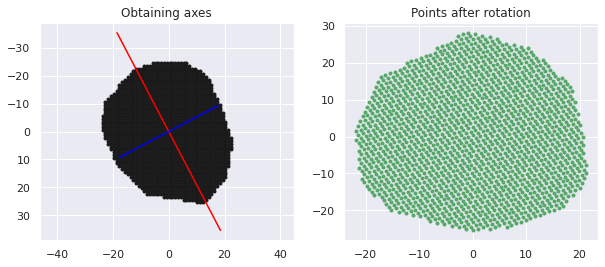

In [ ]:
# Proving work of axis algo
y, x = np.nonzero(imread(segNuc[0]))

x = x - np.mean(x)
y = y - np.mean(y)
coords = np.vstack([x, y])

cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]


scale = 20
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(x, y, 'k.')
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.axis('equal')
plt.gca().invert_yaxis()  # Match the image system with origin at top left
plt.title("Obtaining axes")

theta = np.arctan((x_v1)/(y_v1))
rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
transformed_mat = rotation_mat * coords
#plot the transformed blob
x_transformed, y_transformed = transformed_mat.A
plt.subplot(1,2,2)
plt.plot(x_transformed, y_transformed, 'g.')
plt.title("Points after rotation")
plt.show()


In [ ]:
# Define func to get all features of an image
def features_extract(img, segCyt_3D, segNuc_3D):
  features = []
  features.append(average_intensity(img, segCyt_3D, segNuc_3D))
  features.append(average_contrast(img, segCyt_3D, segNuc_3D))
  features.append(smoothness(img, segCyt_3D, segNuc_3D))
  features.append(uniformity(img, segCyt_3D, segNuc_3D))
  features.append(entropy(img, segCyt_3D, segNuc_3D))
  features.append(area(img, segCyt_3D, segNuc_3D))
  features.append(axis_length(img, segCyt_3D, segNuc_3D))
  features.append(eccentricity(img, segCyt_3D, segNuc_3D))
  features.append(equivalent_diameter(img, segCyt_3D, segNuc_3D))
  features.append(orientation(img, segCyt_3D, segNuc_3D))
  features.append(extent(img, segCyt_3D, segNuc_3D))
  features = [item for t in features for item in t]
  features=np.array(features)
  return features

In [ ]:
# Setting up a table of features extracted for the training images
Features_Train = []
Features_ids = []
Features_abnormal =[]
Features_group = []
for i in range(len(images)):
  ima = imread(images[i])
  cyt = imread(segCyt[i])/255
  cyt_3D = np.stack((cyt,)*3, axis=-1)
  nuc = imread(segNuc[i])/255
  nuc_3D = np.stack((nuc,)*3, axis=-1)
  if (np.sum(cyt_3D)!=0 and np.sum(nuc_3D)!=0):   # In case masks are empty
    Features_ids.append(id[i])
    Features_Train.append(features_extract(ima,cyt_3D,nuc_3D))
    Features_abnormal.append(abnormal[i])
    Features_group.append(group[i])
  
Features_ids = np.array(Features_ids)
Features_Train = np.array(Features_Train)
Features_abnormal = np.array(Features_abnormal)
Features_group = np.array(Features_group)

In [ ]:
# Setting up a table of features extracted for the test images
Features_Test = []
Features_Test_ids = []
for i in range(len(test_images)):
  ima = imread(test_images[i])
  cyt = imread(test_segCyt[i])/255
  cyt_3D = np.stack((cyt,)*3, axis=-1)
  nuc = imread(test_segNuc[i])/255
  nuc_3D = np.stack((nuc,)*3, axis=-1)
  if (np.sum(cyt_3D)!=0 and np.sum(nuc_3D)!=0):   # In case masks are empty
    Features_Test_ids.append(test_ids[i])
    Features_Test.append(features_extract(ima,cyt_3D,nuc_3D))
  
Features_Test_ids = np.array(Features_Test_ids)
Features_Test = np.array(Features_Test)

In [ ]:
Features_Test.shape

(1244, 24)

Extracting the features has proved to be a bigger challenge than I expected. Although having an list of features described in [[2]](https://ieeexplore.ieee.org/document/8451588), there was no information there on how to obtain them. I search for methods in multiples libraries/sources, the most remarkable were credited above. Even with that, there were some references pointing out to different calculation over the same feature. Also, doubts arose, like should the result be normalized? Should I take just one channel of color or should I take a mean of the 3? At last, I couldn’t get consistent results for the “third moment” and “solidity”, consequently, I decided to remove them.<br><br>

At last, running the functions I noticed that some masks aren’t defined (for example "180.bmp" nucleus mask), that is, they only have 0 values. For the scope of the project, I decided to discard this example. However, this once again arises the discussion of how methods that require segmentation are susceptible to more pre-processing and more human error. 
 


#6. Methods over extracted features

Now that I have the extracted features dataset, I can apply some classical methods seen in class over it. To start, I will apply a simple method as a benchmark for the more complex results. The chosen method is the Linear discriminant analysis (LDA) which has as pros an easy interpretation and fast computation, but is still very limited. <br><br>
Then, I will apply a non-linear SVM, due to the fact that different Kernel functions can map our data into different higher dimensional spaces, where it might be well separable by a linear function. At last, I will apply a Random Forest, that is a bagging of decision trees. The random forest has the benefits from the tree, such as being easily interpretable, and minimizes its problems, such as the high variability and chance of overfitting. <br><br>
For all the methods I will be using Cross-validation, so there is no need to create a validation set (we don’t have access to the test labels). For the SVM and Random Forest I will also be using the CV to find the best combination of parameters. <br><br>
Before applying the methods, the data is randomly shuffled to avoid any possible pattern and standardized.



In [ ]:
# Randomly shuffling the data
order=np.arange(0,len(Features_Train))
np.random.shuffle(order)

Features_Train = Features_Train[order[:]]
Features_ids = Features_ids[order[:]]
Features_abnormal = Features_abnormal[order[:]]
Features_group = Features_group[order[:]]

In [ ]:
# Normalizing the features so that they have zero mean and standard deviation
scaler = StandardScaler()
Features_Train = scaler.fit_transform(Features_Train)
Features_Test = scaler.transform(Features_Test)

## 6.1. Binary Classification Problem

### 6.1.1 Linear Discriminant Analysis (LDA)

As can be seen bellow, the LDA gives impressively good results, with a validation score around 91%. The comparison between the Training scores and validation scores indicates that we didn’t fall in an overfitting case (which is unlikely with such a simple model).<br><br>

The good scores in these methods signalize that I indeed did a good job selecting and extracting the features. If not all of them were properly extracted, at least the most important were.


In [ ]:
clf_LDA = LinearDiscriminantAnalysis()
cv_results = cross_validate(clf_LDA, Features_Train, Features_abnormal, cv=5,return_train_score=True)
print("Score on train data: ",cv_results['train_score'])
print("Validation Score: ",cv_results['test_score'])

Score on train data:  [0.91523236 0.91006885 0.91480207 0.91566265 0.92383821]
Validation Score:  [0.90877797 0.9363167  0.92082616 0.91049914 0.90017212]


### 6.1.2 Support Vector machine (SVM)

As expected, the non-linear SVM gives better results, although not that different. The best validation score is almost 96%, using a rbf kernel, and the parameters that can be observed below.

In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(NLsvm, p_grid_nlsvm, cv=5, scoring="accuracy")
grid_nlsvm.fit(Features_Train, Features_abnormal)


print("Best Validation Score: {}".format(grid_nlsvm.best_score_))
print("Score on train data:  ", grid_nlsvm.score(Features_Train, Features_abnormal) )
print("Best params:", grid_nlsvm.best_params_)

Best Validation Score: 0.9583476764199655
Score on train data:   0.9941480206540447
Best params: {'C': 3, 'gamma': 0.1}


In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'degree' : [2, 3, 4,5] }
NLsvm = SVC(kernel='poly')
grid_nlsvm = GridSearchCV(NLsvm, p_grid_nlsvm, cv=5, scoring="accuracy")
grid_nlsvm.fit(Features_Train, Features_abnormal)


print("Best Validation Score: {}".format(grid_nlsvm.best_score_))
print("Score on train data:  ", grid_nlsvm.score(Features_Train, Features_abnormal) )
print("Best params:", grid_nlsvm.best_params_)

Best Validation Score: 0.9483648881239242
Score on train data:   0.9824440619621343
Best params: {'C': 9, 'degree': 3}


### 6.1.3. Random Forest

Again, the Random forest gives better results than the LDA (expected), but the model fitted the problem worst than SVM, with a validation score over 94%. The results observed in this both more complex methods also signalize for a good feature extraction.

In [ ]:
# CV over Random Forest
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2'],'criterion' : ['entropy', 'gini']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(Features_Train, Features_abnormal)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Random Forest train score :",grid_RF.score(Features_Train, Features_abnormal))
print("Best params: {}".format(grid_RF.best_params_))

Best Validation Score: 0.9459552495697073
Random Forest train score : 0.9893287435456111
Best params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}


## 6.2. Multi-class Classification Problem

### 6.2.1. Linear Discriminant Analysis (LDA)

As expected, the multiclass problem is more difficult, thus having worst results. In it, we still have the problem mentioned above of the unbalanced classes. The scores for the LDA are still acceptable, being around 84% for the validation set.

In [ ]:
clf_LDA = LinearDiscriminantAnalysis()
cv_results = cross_validate(clf_LDA, Features_Train, Features_group, cv=5,return_train_score=True)
print("Score on train data: ",cv_results['train_score'])
print("Validation Score: ",cv_results['test_score'])

Score on train data:  [0.84509466 0.84595525 0.85068847 0.84509466 0.84853701]
Validation Score:  [0.83820998 0.84165232 0.83648881 0.84681583 0.83476764]


### 6.2.2. Support Vector machine (SVM)

Again, the rbf kernel shows the best results for the multiclass classification problem. As seen bellow the results for the validation score are over 87%, which is not very far of the results presented in [[2]](https://ieeexplore.ieee.org/document/8451588).

In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(NLsvm, p_grid_nlsvm, cv=5, scoring="accuracy")
grid_nlsvm.fit(Features_Train, Features_group)


print("Best Validation Score: {}".format(grid_nlsvm.best_score_))
print("Score on train data:  ", grid_nlsvm.score(Features_Train, Features_group) )
print("Best params:", grid_nlsvm.best_params_)

Best Validation Score: 0.874354561101549
Score on train data:   0.9060240963855422
Best params: {'C': 5, 'gamma': 0.01}


In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'degree' : [2, 3, 4,5] }
NLsvm = SVC(kernel='poly')
grid_nlsvm = GridSearchCV(NLsvm, p_grid_nlsvm, cv=5, scoring="accuracy")
grid_nlsvm.fit(Features_Train, Features_group)


print("Best Validation Score: {}".format(grid_nlsvm.best_score_))
print("Score on train data:  ", grid_nlsvm.score(Features_Train, Features_group) )
print("Best params:", grid_nlsvm.best_params_)

Best Validation Score: 0.8454388984509466
Score on train data:   0.9652323580034423
Best params: {'C': 10.0, 'degree': 3}


### 6.2.3. Random Forest

Again, the scores are worst than found in SVM, being equal to 83.5% for the validation set.

In [ ]:
# CV over Random Forest
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2'],'criterion' : ['entropy', 'gini']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(Features_Train, Features_group)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Random Forest train score :",grid_RF.score(Features_Train, Features_group))
print("Best params: {}".format(grid_RF.best_params_))

Best Validation Score: 0.8347676419965577
Random Forest train score : 0.9700516351118761
Best params: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 30}


#7. Convolutional neural network (CNN)

**Using Convolutional neural network (CNN) have multiple benefits in theory in comparison to the previously used methods.**<br><br>

Comparing it to the MLP, another type of Artificial Neural Network (ANN), it doesn’t need fully connected layers, which has high redundancy in weights. Specially in the case of images and other grid like topological structures, in which the number of parameters increase rapidly and usually in an unnecessary way. Using the convolution operation reduces the number of parameters to train, making the training faster, but also minimizes the chance of falling into a local minimum during optimization.<br><br>
One other advantage of using CNN is that we can obtain shift invariance property through Max pooling, that is, being able to detect objects wherever they are in the image.<br><br>

For that reason, using the CNN allow us to work directly over the image, without having to manually extract the features, which has proven to be a challenge. Also as mentioned in [[3]](https://pubmed.ncbi.nlm.nih.gov/28541229/), CNNs don’t need the manually segmented cytoplasm and nucleus masks. This is beneficial, firstly because it saves time and effort (as having a specialist manually segmenting each image is probably a bottleneck in the process); secondly, it can decrease the error, since there can be human errors in the segmentation. <br><br>

Therefore, a simple classification CNN architecture often consists of:

$$ Convolution \rightarrow biases\rightarrow non-linearities \rightarrow  subsampling $$

After this, a classification section is used:

$$Fully\;connected\;layer \rightarrow non-linearity $$


## 7.1. Reworking on the data

As already mentioned in the beginning of the work, we need to rework the data so that we can used as entry of our CNN. <br><br>
First of all, we will resize all the images to a uniform size. The 224x224 was chosen as is the size as most Imagenet pretrained CNNs were trained on that image resolution. By doing that, we will be able to construct our X_train tensor, that has 4 dimensions; the first having size equal to the number of images; 2nd and 3rd equal to 224 and at last the 4th with size equal to 3, corresponding to the 3 color channels. <br><br>
As also proposed in [[3]](https://pubmed.ncbi.nlm.nih.gov/28541229/) we will subtract the mean image over the training set from the original image. After that preprocessing the input and randomly shuffling the images to guarantee that there will be no pattern in their order.


In [ ]:
# Images to the same size
X_Train = np.zeros((len(images),224,224,3))
for i in range(len(images)):
  img = imread(images[i])
  resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
  X_Train[i,:,:,:] = resized

X_Test = np.zeros((len(test_images),224,224,3))
for i in range(len(test_images)):
  img = imread(test_images[i])
  resized = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
  X_Test[i,:,:,:] = resized

In [ ]:
# preprocess the input
X_Train = X_Train.astype('float32')
X_Train /= 255

X_Test = X_Test.astype('float32')
X_Test /= 255

In [ ]:
# Standardizing the images so that they have zero mean
X_Train = X_Train - np.mean(X_Train, axis=0)
X_Test = X_Test - np.mean(X_Train, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

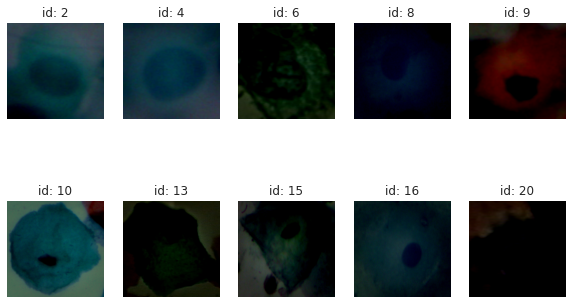

In [ ]:
# Plotting examples from first images
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    plt.imshow(X_Train[idx])
    plt.axis('off')
    plt.title("id: "+str(id[idx]))
plt.show()

In [ ]:
# Randomly shuffling the data
order=np.arange(0,len(X_Train))
np.random.shuffle(order)

X_Train = X_Train[order[:]]
id = id[order[:]]
abnormal = abnormal[order[:]]
group = group[order[:]]

## 7.2. Binary Classification Problem

### 7.2.1. Simple Model

For a first try, we will be implementing a simple CNN model, similar to the ones used in the practical works of the course.

In [ ]:
learning_rate = 0.01
n_epochs = 20
batch_size = 64
# number of convolutional filters to use
nb_filters = 32 

# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successice layers
n_h_0 = 3
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

input_shape = (224,224,3)

In [ ]:
simple_model = Sequential()
simple_model.add(Conv2D(nb_filters,kernel_size,activation='relu',strides=(1, 1), padding="same", input_shape=input_shape, name='Conv1'))
simple_model.add(Conv2D(nb_filters,kernel_size,activation='relu',strides=(1, 1), padding="same"))
simple_model.add(MaxPooling2D((2, 2),strides=(2,2)))
simple_model.add(Conv2D(nb_filters,kernel_size,activation='relu',strides=(1, 1), padding="same"))
simple_model.add(MaxPooling2D((2, 2),strides=(2,2)))
simple_model.add(Flatten())
simple_model.add(Dense(1,activation='sigmoid'))

In [ ]:
# compile model
simple_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate),metrics=["accuracy"])

# display model
simple_model.summary()

# fit model
simple_model.fit(X_Train, abnormal, epochs=20, batch_size=64,  validation_split=0.3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

As can be seen above, this simple model gives us something above 83% of accuracy for the validation set. That is in fact considerably worst of what was obtained with the feature extraction, even if you taken into account that we don’t have to go over the extra work of extracting the features. But compared to the results in the reference papers for a CNN (in the multiclass case, which is more difficult), this result is also really bellow the expected.

### 7.2.2. Transfer Learning

As the simple model above didn’t give really good results, again we will follow the procedure in [[3]](https://pubmed.ncbi.nlm.nih.gov/28541229/) and use transfer learning. This refers to the fine-tuning of deep learning models that are pre-trained on other large-scale image datasets, in this case ImageNet. The schema of using transfer learning can be seen bellow (extracted from [[3]](https://pubmed.ncbi.nlm.nih.gov/28541229/)).

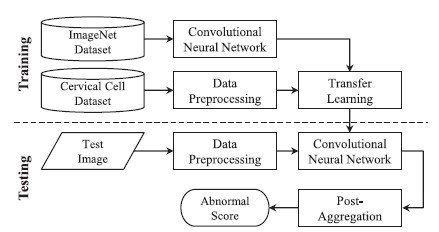



In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Defining other important layers
prediction_layer = tf.keras.layers.Dense(1,"sigmoid")
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Data augmentation is a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such linear transformations. This helps expose the model to different aspects of the training data and reduce overfitting.<br><br>
This is a method also used in [[3]](https://pubmed.ncbi.nlm.nih.gov/28541229/). The examples of the data augmentation can be seen below in one example image. As the cells are usually in something resembling a round/ ellipsoid shape, the differences when applying rotations are not so evident for an untrained eye, however during test it seems to improve results.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


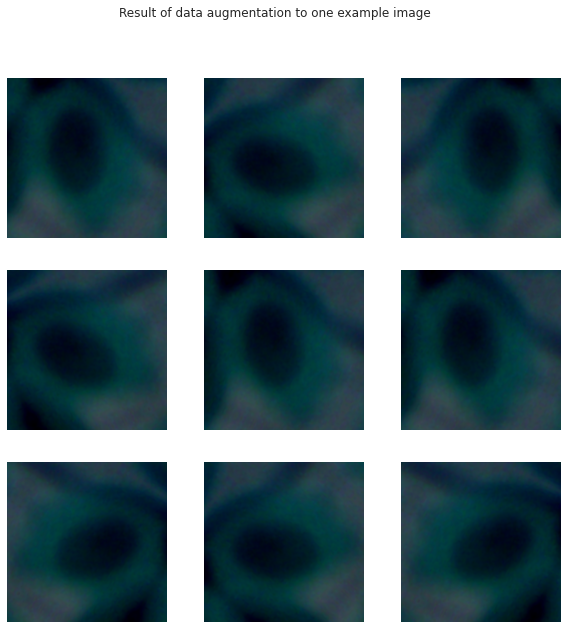

In [ ]:
plt.figure(figsize=(10, 10))
first_image = X_Train[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')
plt.suptitle('Result of data augmentation to one example image')
plt.show()

I tried multiples pre-trained architectures, such as VGG and Resnet (the full list can be found in [Keras documentation]( https://www.tensorflow.org/api_docs/python/tf/keras/applications)). Following the same process for all, MobileNet was the one that seemed to have the best results (remarking that there are probably better set parameters for the other pre-trained networks). To make this report more concise and more readable, I decided to only leave the MobileNet example, as it fully illustrates the idea of the transfer learning procedure. <br><br>
Bellow can be seeing the summary of MobileNet and the summary of my model.<br><br>
Some other implementation choices that are worth mentioning is the use of Dropout regularization. Dropout involves randomly turning off neurons. This removes different paths in the network aiming to find robust connections to represent the data, thus avoiding overfitting.<br><br>
Also, for the optimization Adam will be used. At the same time, it takes advantage of the momentum (a term added to the gradient update which helps stabilize training) and normalizes the learning rate by the recent magnitude of the gradient.


In [ ]:
# Importing pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
# Freezing layers so that they aren’t trainable 
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# Building our model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = Dense(1280, activation="relu")(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy',MCC])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 1280)        1639680   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281

In [ ]:
history = model.fit(X_Train, abnormal, batch_size=64, epochs=20,  validation_split=0.3)

Epoch 1/20
32/32 [==============================] - 8s 154ms/step - loss: 0.5291 - accuracy: 0.7158 - MCC: 0.4687 - val_loss: 0.2781 - val_accuracy: 0.8928 - val_MCC: 0.7813
Epoch 2/20
32/32 [==============================] - 4s 127ms/step - loss: 0.2589 - accuracy: 0.8956 - MCC: 0.7886 - val_loss: 0.2757 - val_accuracy: 0.8803 - val_MCC: 0.7630
Epoch 3/20
32/32 [==============================] - 4s 128ms/step - loss: 0.2277 - accuracy: 0.9085 - MCC: 0.8174 - val_loss: 0.2424 - val_accuracy: 0.8962 - val_MCC: 0.7924
Epoch 4/20
32/32 [==============================] - 4s 128ms/step - loss: 0.2152 - accuracy: 0.9224 - MCC: 0.8438 - val_loss: 0.2034 - val_accuracy: 0.9247 - val_MCC: 0.8474
Epoch 5/20
32/32 [==============================] - 4s 127ms/step - loss: 0.1921 - accuracy: 0.9280 - MCC: 0.8543 - val_loss: 0.2232 - val_accuracy: 0.9076 - val_MCC: 0.8142
Epoch 6/20
32/32 [==============================] - 4s 127ms/step - loss: 0.1778 - accuracy: 0.9329 - MCC: 0.8636 - val_loss: 0.18

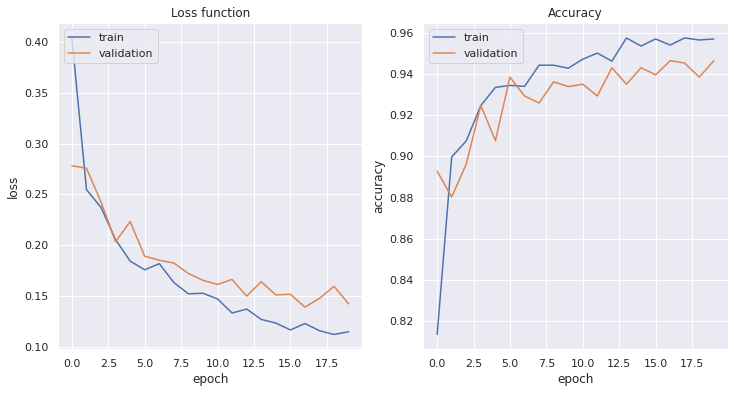

In [ ]:
# summarize history for loss
fig, axs = plt.subplots(1, 2,figsize=(12, 6))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss function')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')

plt.show()

In [ ]:
# Predicting classes for test set
predict = model.predict(X_Test)
c=np.zeros(predict.size)
for i in range(predict.size):
  if predict[i] <0.5:
    c[i]=0
  else:
    c[i]=1

Using the transfer learning technique improve considerably the results. The accuracy improved more that 10%, and got above 94%.  The Matthews correlation coefficient that is used as metric in the Kaggle competition on the other hand is above 89% for the validation set.Above can be seen the graphs of evolution of the loss and accuracy for each epoch, through which we are certain that the model is not overfitting. <br><br>

One extra remark about the graph is that the results for the validation set are better for the train set in the first epochs. According to the Keras documentation this is normal, and can be due to either the fact that the train lost/accuracy is e mean between batches, and the results of the first batches tend to be worst; either because we are using dropout, and for validation the neurons that were turned off in the training are turned back on, giving better results. <br><br>

Again, the reference papers suggest that better results can be obtained, but for the scope of a class project, I would consider them acceptable. Even though results are now equivalent to the feature extraction, we have the advantage of not needing the segmentations or doing a lot of pre-processing. 





## 7.3. Multi-class Classification Problem

As creating and training a CNN from scratch has already proven to not given really good results in the binary classification, for the multiclass-classification we will skip directly for the transfer learning. Therefore, all the remarks made before are once again valid. The only difference between the network applied before and now is that the sigmoid function in the classification layer was substituted by a softmax, to take into account the 9 classes.

In [ ]:
# Creating class weights to unbalanced dataset
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(group),
                                                 group)
class_weights = dict(enumerate(class_weights))

# First of all we need to apply the one-hot encoding to the labels,
# for the multiclass classification problem.
y_train = tf.keras.utils.to_categorical(group) 

In [ ]:
prediction_layer = tf.keras.layers.Dense(9,"softmax")

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = Dense(1280, activation="relu")(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["categorical_accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 7, 7, 1280)        1639680   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1152

In [ ]:
history = model.fit(X_Train, y_train, batch_size=64, epochs=30,  validation_split=0.3, class_weight=class_weights)

Epoch 1/30
32/32 [==============================] - 8s 151ms/step - loss: 0.3959 - categorical_accuracy: 0.3263 - val_loss: 0.1919 - val_categorical_accuracy: 0.7024
Epoch 2/30
32/32 [==============================] - 4s 126ms/step - loss: 0.2356 - categorical_accuracy: 0.6855 - val_loss: 0.1508 - val_categorical_accuracy: 0.7377
Epoch 3/30
32/32 [==============================] - 4s 127ms/step - loss: 0.1981 - categorical_accuracy: 0.7514 - val_loss: 0.1338 - val_categorical_accuracy: 0.7708
Epoch 4/30
32/32 [==============================] - 4s 127ms/step - loss: 0.1866 - categorical_accuracy: 0.7672 - val_loss: 0.1255 - val_categorical_accuracy: 0.7765
Epoch 5/30
32/32 [==============================] - 4s 126ms/step - loss: 0.1793 - categorical_accuracy: 0.7807 - val_loss: 0.1178 - val_categorical_accuracy: 0.7925
Epoch 6/30
32/32 [==============================] - 4s 127ms/step - loss: 0.1665 - categorical_accuracy: 0.7994 - val_loss: 0.1123 - val_categorical_accuracy: 0.8050
Epoc

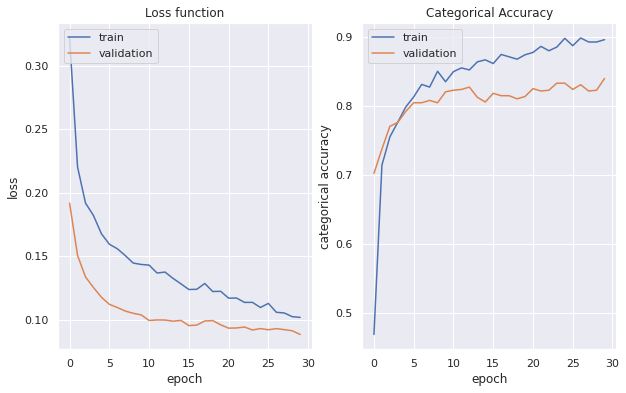

In [ ]:
# summarize history for loss
fig, axs = plt.subplots(1, 2,figsize=(10, 6))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss function')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for accuracy
axs[1].plot(history.history['categorical_accuracy'])
axs[1].plot(history.history['val_categorical_accuracy'])
axs[1].set_title('Categorical Accuracy')
axs[1].set_ylabel('categorical accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')

plt.show()

In [ ]:
# Predicting classes for test set
predict = model.predict(X_Test)
c=np.zeros(predict.shape[0])
for i in range(predict.shape[0]):
  c[i]=np.argmax(predict[i])

For the multiclass classification problem, the validation set results were around 84%. This was obtained defining the class weights in the model, that were taken to compensate the fact that we had an unbalanced dataset. Although these results are worst than the ones obtained in the binary class problem (which is expected), I would consider them good, especially taken into account the extra problem of imbalance.

# 8. Conclusion

This concludes the project for the IMA205 course, which consisted in two classification problems: one binary and one multiclass; over a set of images of cells prevenient of Pap smear tests. This project was a great opportunity to put in practice the contents seen during class, in a more realistic way than in the practical labs. <br><br>
Extracting the features from the images, so that they could be used over traditional machine learning methods proved to be a challenge, but that I consider to have succeeded, obtaining really reasonable results.
As for the CNN, that according to the references on the subject seems to be the currently used method in practice, I acknowledge that the results weren’t as good as expected. However, the CNN can infinitely vary with different layers, parameters, pretrained networks, which I have just began to explore. 


# 9. References 
[1] https://mde-lab.aegean.gr/downloads<br>
[2] [M. E. Plissiti, P. Dimitrakopoulos, G. Sfikas, C. Nikou, O. Krikoni and A. Charchanti, "Sipakmed: A New Dataset for Feature and Image Based Classification of Normal and Pathological Cervical Cells in Pap Smear Images," 2018 25th IEEE International Conference on Image Processing (ICIP), 2018, pp. 3144-3148, doi: 10.1109/ICIP.2018.8451588.](https://ieeexplore.ieee.org/document/8451588)<br>
[3] [Zhang L, Le Lu, Nogues I, Summers RM, Liu S, Yao J. DeepPap: Deep Convolutional Networks for Cervical Cell Classification. IEEE J Biomed Health Inform. 2017 Nov;21(6):1633-1643. doi: 10.1109/JBHI.2017.2705583. Epub 2017 May 19. PMID: 28541229.](https://pubmed.ncbi.nlm.nih.gov/28541229/)

In [ ]:
# Code for submission
#data = {'ID':  Features_Test_ids,
#        'GROUP': y_pred_2
#        }
#df = pd.DataFrame(data, columns = ['ID','GROUP'])
#from google.colab import files
#df.to_csv('filename.csv') 
#files.download('filename.csv')